#

# Peer-induced fairness framework for algorithmic bias auditing

###

* Example: sensitive attribute = firm's size, we treat micro-firms as protected group and non-micro firms as non-protected group
* Data: we collect data from UK Archive Small and Medium-Sized Enterprise Finance Monitor https://doi.org/10.5255/UKDA-SN-6888-26
* Peer identification threshold in this file is $0.3 \times Std_{IC}$, fitting model: logistic, prediction model: logistic

#

## (1) Data Preprocessing

In [1]:
import sys
sys.path.append("../..")
import preprocess

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd

# Paths to the tab data files
data_paths = [
    '../datasets/SMEs_F/raw/sme_finance_monitor_q4_2012-q1_2015_data.tab',
    '../datasets/SMEs_F/raw/sme_finance_monitor_q3_2015_q4_2017.tab',
    '../datasets/SMEs_F/raw/sme_finance_monitor_q1_2018-q2_2020.tab'
]

# Combine the dataframes
df_list = [pd.read_csv(path, sep='\t') for path in data_paths]  # Assuming tab-separated values
df_count = pd.concat(df_list, ignore_index=True)

# Get the total number of entries
total_entries = df_count.shape[0]
print(f"The total number of entries in the combined dataset is: {total_entries}")

C:\Users\s2285280\AppData\Local\Temp\ipykernel_6812\1558928240.py:11: DtypeWarning: Columns (13,41,42,49,52,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,1907,1908,1911,1912,1913,1914,1933,1938,1939,1940,1941,1942,1943,1944,1945,1946,1963,2002,2003,2114,2115,2116,2117,2118,2119,2120,2121,2122,2123,2124,2125,2126,2127,2128,2129,2130,2131,2132,2133,2148,2149,2150,2151,2152,2153,2156,2157,2158,2159,2160,2161,2162,2163,2164,2165,2166,2167,2168,2169,2170,2171,2172,2173,2174,2175,2176,2177,2178,2179,2180,2181,2182,2210,2215,2216,2217,2218,2219,2220,2225,2227) have mixed types. Specify dtype option on import or set low_memory=False.
  df_list = [pd.read_csv(path, sep='\t') for path in data_paths]  # Assuming tab-separated values


The total number of entries in the combined dataset is: 141166


In [3]:
# Step1: Combine dataframe
# ..represent the previous layer
df_combined = data_preprocess.combine_data(['../datasets/SMEs_F/raw/sme_finance_monitor_q4_2012-q1_2015_data.tab',
                                            '../datasets/SMEs_F/raw/sme_finance_monitor_q3_2015_q4_2017.tab',
                                            '../datasets/SMEs_F/raw/sme_finance_monitor_q1_2018-q2_2020.tab'],
                                            ['../datasets/SMEs_F/selection/selectedfeatures1.csv',
                                             '../datasets/SMEs_F/selection/selectedfeatures2.csv',
                                             '../datasets/SMEs_F/selection/selectedfeatures3.csv'],
                                             '../datasets/SMEs_F/selection/common_featuresname.csv')

In [5]:
# Step 2: Replace DK/Refused data
df_replace_dk_refused = preprocess.replace_dk_refused(df_combined)
# Step 3: Replace missing values in the combined data
replacena_df = preprocess.replace_missing_values(df_replace_dk_refused)
# Step 4: Check column-wise missing ratio and select columns with ratio <= 0.5
del_hmc_df, NAN_ratios, keep_columns = preprocess.check_col_missing_ratio(replacena_df, 0.5)
# Step 5: Check row-wise missing ratio and select rows with ratio < 0.2
del_hmr_df = preprocess.check_row_missing_ratio(del_hmc_df, 0.2)
# Step 6: Impute missing data in the selected columns
fill_df = preprocess.impute_missing_data(del_hmr_df)
# Step 7: Convert data to integer type
int_df = preprocess.convert_to_int(fill_df)
# Step 8: Remove NAN Final Outcomes
delfona_df = preprocess.remove_nan_final_outcomes(int_df)
# Step 9: Merge final outcomes
part_mergefo_df, all_mergefo_df = preprocess.merge_final_outcomes(delfona_df, int_df)
# Step 10: Merge regular and sensitve attributes
merge_df, int_merge_df = preprocess.merge_attributes(part_mergefo_df, all_mergefo_df)
# Step 11: Export csv and xlsx
# data_preprocess.export_csv(merge_df, int_merge_df)
# data_preprocess.export_xlsx(merge_df, int_merge_df)

C:\Users\s2285280\peer-induced-fairness\preprocess.py:242: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  delfo5_df = delfo5_df[delfona_df['final outcomes'] != 5.0]
C:\Users\s2285280\peer-induced-fairness\preprocess.py:243: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  delfo5_df = delfo5_df[delfona_df['final outcomes'] != '5']


In [8]:
columns_to_drop = ['gender', 'age','race','new gender','new race','new age', 'establish time', 'location', 'new annual turnover','annual turnover','workers number', 'new workers number', 'funds injections', 'size', 'final outcomes']

merge_df = merge_df.drop(columns=columns_to_drop)

In [9]:
nominals = ['principal', 'legal status']
ordinals = [col for col in merge_df.columns if col not in nominals]

In [10]:
from preprocess import FeatureEncoder

drop_list = ['Binary Y', 'new size']

X_part = merge_df.drop(drop_list, axis=1)
X_part_nominals = [x for x in X_part if x in nominals]


part_encoder = FeatureEncoder(X_part)
X_part_encoded_df = part_encoder.one_hot_encode(columns=X_part_nominals)

#

# (2) Fitting

In [12]:
from auditing import LogisticRegressionModel

# train model for membership
model = LogisticRegressionModel(X_part_encoded_df, merge_df['new size'])
model.train_model()
model.evaluate_performance()
model.generate_test_report()
model.calculate_auc()
model.calculate_acc()
model.calculate_f1()
model.calculate_recall()
model.calculate_precision()



# prediction
X_part = X_part_encoded_df
yb_pred_all = model.predict_proba(X_part)
yb_prediction_all = model.predict(X_part)

# add prediction results
merge1_df = merge_df.copy()
merge1_df['Pr(S=0)'] = yb_pred_all[:, 0]
merge1_df['PS Prediction'] = yb_prediction_all

5-fold Cross Validation AUC: [0.85975029 0.82159026 0.83752204 0.83786456 0.83608648]
Mean AUC: 0.8385627266060827
Standard Deviation of the Mean AUC: 0.01220393015541242
Standard Error of the Mean AUC: 0.00610196507770621
5-fold Cross Validation Accuracy: [0.79086538 0.76322115 0.76682692 0.765625   0.76052948]
Mean Accuracy: 0.769413588817921
Standard Deviation of the Mean Accuracy: 0.010940725596247904
Standard Error of the Mean Accuracy: 0.005470362798123952
5-fold Cross Validation Precision: [0.79182156 0.78034682 0.7752809  0.76588022 0.75849732]
Mean Precision: 0.7743653630893277
Standard Deviation of the Mean Precision: 0.011533668007870417
Standard Error of the Mean Precision: 0.005766834003935207
5-fold Cross Validation Recall: [0.87295082 0.82991803 0.84836066 0.8647541  0.86885246]
Mean Recall: 0.8569672131147541
Standard Deviation of the Mean Recall: 0.0158940323193978
Standard Error of the Mean Recall: 0.0079470161596989
5-fold Cross Validation F1: [0.83040936 0.80436941 

#

# (3) Prediction

In [13]:
# train model for favourable outcomes likelihood
model = LogisticRegressionModel(X_part_encoded_df, merge_df['Binary Y'])
model.train_model()
model.evaluate_performance()
model.generate_test_report()
model.calculate_auc()
model.calculate_acc()
model.calculate_f1()
model.calculate_recall()
model.calculate_precision()

# prediction
X_part = X_part_encoded_df
yb_pred_all = model.predict_proba(X_part)
yb_prediction_all = model.predict(X_part)

# add prediction results
merge_pred_ps_df = merge1_df.copy()
merge_pred_ps_df['Pr(Y=1)'] = yb_pred_all[:, 1]
merge_pred_ps_df['Binary Prediction'] = yb_prediction_all

5-fold Cross Validation AUC: [0.73073628 0.68692296 0.80880071 0.82740968 0.82877841]
Mean AUC: 0.7765296102212549
Standard Deviation of the Mean AUC: 0.05742216380805111
Standard Error of the Mean AUC: 0.028711081904025555
5-fold Cross Validation Accuracy: [0.81490385 0.79447115 0.85216346 0.84735577 0.84837545]
Mean Accuracy: 0.8314539364065536
Standard Deviation of the Mean Accuracy: 0.0228461028479526
Standard Error of the Mean Accuracy: 0.011423051423976299
5-fold Cross Validation Precision: [0.82129743 0.81727159 0.8665786  0.85919166 0.86315789]
Mean Precision: 0.8454994338763775
Standard Deviation of the Mean Precision: 0.021569319059361346
Standard Error of the Mean Precision: 0.010784659529680673
5-fold Cross Validation Recall: [0.98821797 0.96312684 0.96755162 0.9719764  0.96755162]
Mean Recall: 0.9716848914549855
Standard Deviation of the Mean Recall: 0.008727377528964873
Standard Error of the Mean Recall: 0.004363688764482437
5-fold Cross Validation F1: [0.89705882 0.88422

#

# (4) Categorise to nonprotected and protected groups

In [14]:
# data preparation
import auditing

protect_df, nonprotect_df, accepted_df, rejected_df, pred_accepted_df, pred_rejected_df, protect_ps, nonprotect_ps = auditing.data_divide(merge_pred_ps_df, 'new size','Binary Y', 'Binary Prediction', 'Pr(S=0)')

#

# (5) Peer identification

In [15]:
from auditing import CaplierMatching

matcher = CaplierMatching(merge_pred_ps_df, 'new size', K=15, caplier_ratio=0.3)
matched_df = matcher.caplier_matching()
a, b, weighted_protect_ps, weighted_nonprotect_ps = matcher.calculate_weighted_ps()

#

# (6) Test

In [16]:
from auditing import BootstrapSampler

sampler = BootstrapSampler(nonprotect_df, protect_df, matched_df,sampling_times=100, draws_per_sample=30, determine=35)
bootstrapped_samples = sampler.sample()
pr_y_means = sampler.calculate_means(bootstrapped_samples)

single_less_sided_results = sampler.perform_test(pr_y_means, direction='less')
single_greater_sided_results = sampler.perform_test(pr_y_means, direction='greater')
double_sided_results = sampler.perform_test(pr_y_means, direction='two-sided')

#

# (7) Visualisation

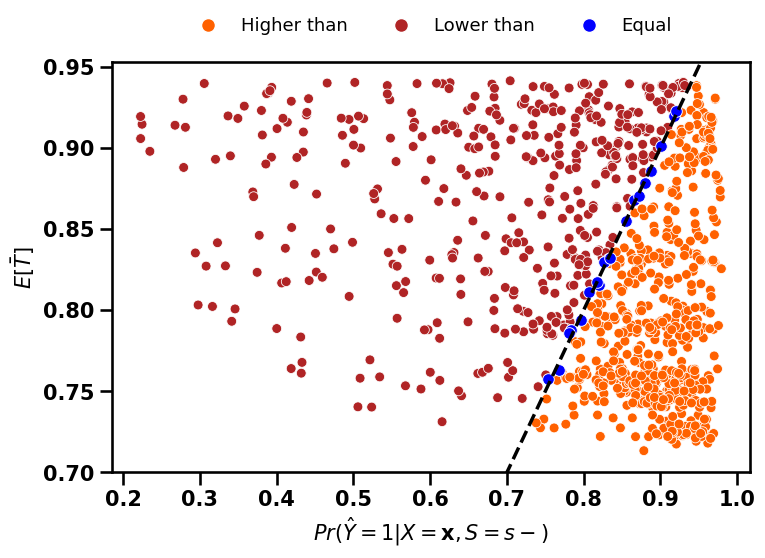

In [17]:
plot_df = sampler.plot_treatment_comparison(pr_y_means,double_sided_results)

#

# (8) Treatment categories

In [18]:
treatment_threshold = 0.2 * protect_df['Pr(Y=1)'].std()

## 8.1 Extreme discrimination

Number of colored points: 269


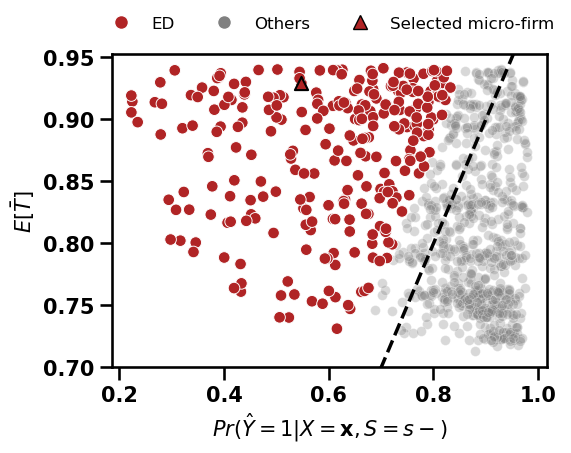

the data ratio is: 0.2671300893743793
#B02425 Protected Pr(Y=1) Mean: 0.6025916198193579, Standard Deviation: 0.15256726275194898
#B02425 Matched Mean Pr(Y=1) Mean: 0.8747210051843345, Standard Deviation: 0.05410670147618545


C:\Users\s2285280\peer-induced-fairness\auditing.py:695: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=False`.
This will become an error in seaborn v0.14.0; please update your code.

  ax = sns.kdeplot(data1, shade=False, color=color, linewidth=7, label='Micro-firms', linestyle='--')
C:\Users\s2285280\peer-induced-fairness\auditing.py:696: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=False`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data2, shade=False, color=density_color, linewidth=7, label='Peers group')


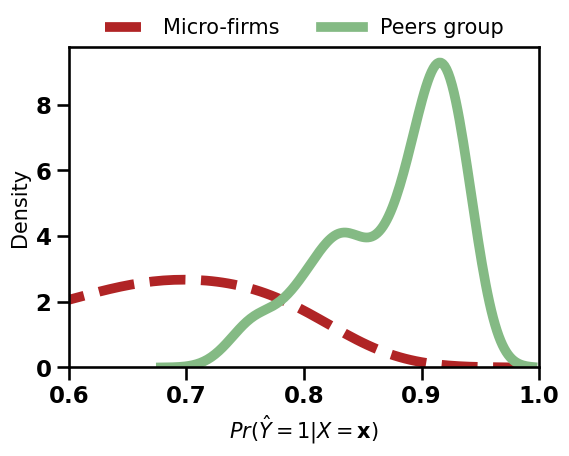

Kurtosis: 0.5947451300415443
Standard Deviation: 0.005666974625970285
Density Mean: 0.9295099324320526
Line Value (A): 0.547504564972857


C:\Users\s2285280\peer-induced-fairness\auditing.py:1053: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=False`.
This will become an error in seaborn v0.14.0; please update your code.

  ax = sns.kdeplot(data, shade=False, bw_adjust=bw_adjust, color=density_color, linewidth=7, label='Peers')


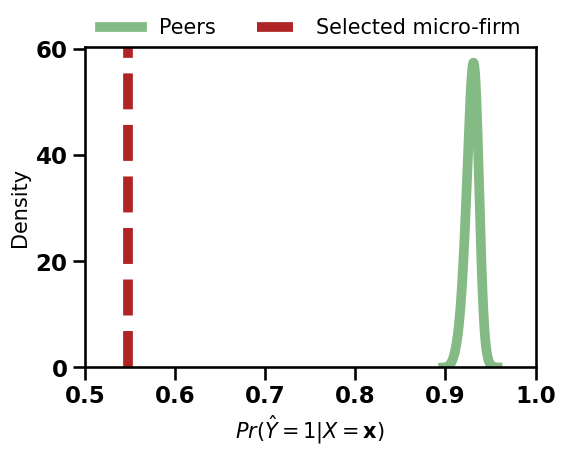

In [19]:
from auditing import DensityScatterPlotter

plotter = DensityScatterPlotter(protect_df, nonprotect_df, bootstrapped_samples, result_type='single_greater_sided_results', comparison_type='less than')

single_greater_less_than_plot_df, single_greater_less_than_gray_df, single_greater_less_than_color_df = plotter.plot_scatter(pr_y_means, 0, single_greater_sided_results, threshold_type='floating', floating_ratio=0.1, mean_diff_threshold=treatment_threshold, p_value_threshold=0.05)

plotter.plot_group_density(single_greater_less_than_color_df, 'protected Pr(Y=1)', 'matched mean Pr(Y=1)', '#B02425', density_color='#84BA84')
plotter.plot_case_density(protect_df,pr_y_means, 0, show_line=True, line_color='#B02425', density_color='#84BA84')

In [20]:
line_1,b = plotter.try_2(single_greater_less_than_color_df,pr_y_means,label='single_greater_less than')

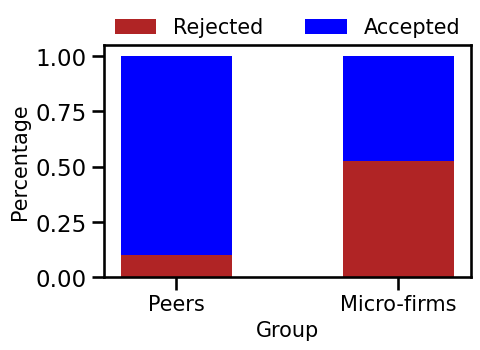

,Type,Binary Y,Count,Proportion
0,Nonprotect,0,80649,0.099937
1,Nonprotect,1,726351,0.900063
2,Protect,0,141,0.524164
3,Protect,1,128,0.475836


In [21]:
single_greater_less_than_group_results = plotter.group_ground_truth(single_greater_less_than_color_df,label='single_greater_less than')
single_greater_less_than_group_results

## 8.2 Slight discrimination

Number of colored points: 155


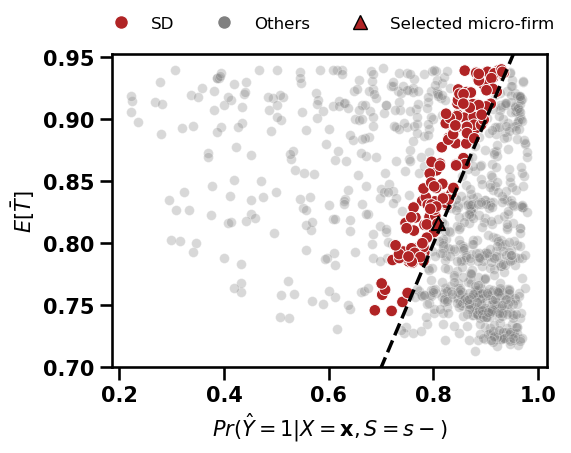

the data ratio is: 0.15392254220456802
#B02425 Protected Pr(Y=1) Mean: 0.8319284269394756, Standard Deviation: 0.05816405288431004
#B02425 Matched Mean Pr(Y=1) Mean: 0.8673268115457526, Standard Deviation: 0.05437960446701502


C:\Users\s2285280\peer-induced-fairness\auditing.py:695: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=False`.
This will become an error in seaborn v0.14.0; please update your code.

  ax = sns.kdeplot(data1, shade=False, color=color, linewidth=7, label='Micro-firms', linestyle='--')
C:\Users\s2285280\peer-induced-fairness\auditing.py:696: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=False`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data2, shade=False, color=density_color, linewidth=7, label='Peers group')


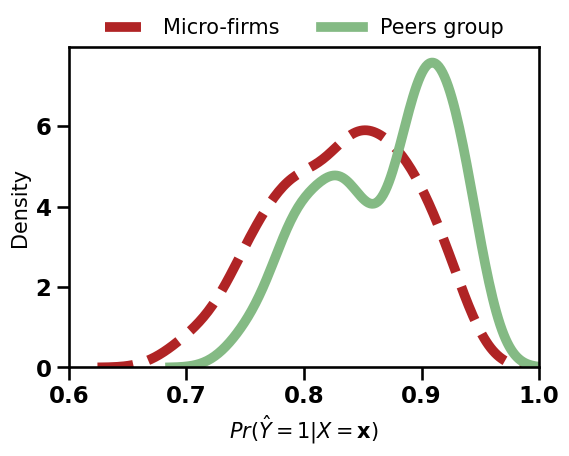

Kurtosis: -0.08554062925210415
Standard Deviation: 0.022017981076284745
Density Mean: 0.8161529608786126
Line Value (A): 0.8076757914267139


C:\Users\s2285280\peer-induced-fairness\auditing.py:1053: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=False`.
This will become an error in seaborn v0.14.0; please update your code.

  ax = sns.kdeplot(data, shade=False, bw_adjust=bw_adjust, color=density_color, linewidth=7, label='Peers')


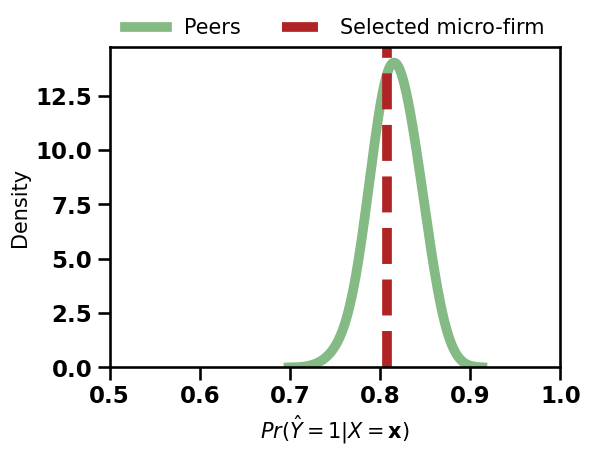

In [22]:
plotter = DensityScatterPlotter(protect_df, nonprotect_df, bootstrapped_samples, result_type='single_greater_sided_results', comparison_type='between')
single_greater_between_plot_df, single_greater_between_gray_df, single_greater_between_color_df = plotter.plot_scatter(pr_y_means, 1629, single_greater_sided_results, threshold_type='floating', floating_ratio=0.1, mean_diff_threshold=treatment_threshold, p_value_threshold=0.05)

plotter.plot_group_density(single_greater_between_color_df, 'protected Pr(Y=1)', 'matched mean Pr(Y=1)', '#B02425', density_color='#84BA84')
plotter.plot_case_density(protect_df,pr_y_means, 1629, show_line=True, line_color='#B02425', density_color='#84BA84')

In [23]:
line_2,b = plotter.try_2(single_greater_between_color_df,pr_y_means,label='single_greater_between')

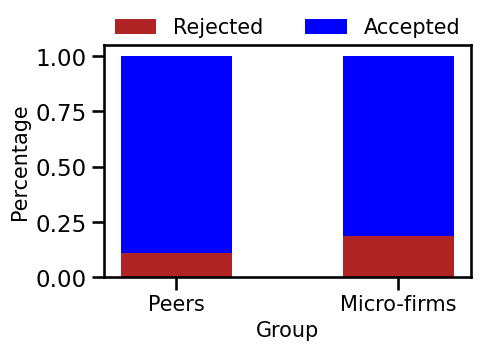

,Type,Binary Y,Count,Proportion
0,Nonprotect,0,50765,0.109172
1,Nonprotect,1,414235,0.890828
2,Protect,0,29,0.187097
3,Protect,1,126,0.812903


In [24]:
single_greater_between_group_results = plotter.group_ground_truth(single_greater_between_color_df,label='single_greater_between')
single_greater_between_group_results

## 8.3 Fairly treated

Number of colored points: 20


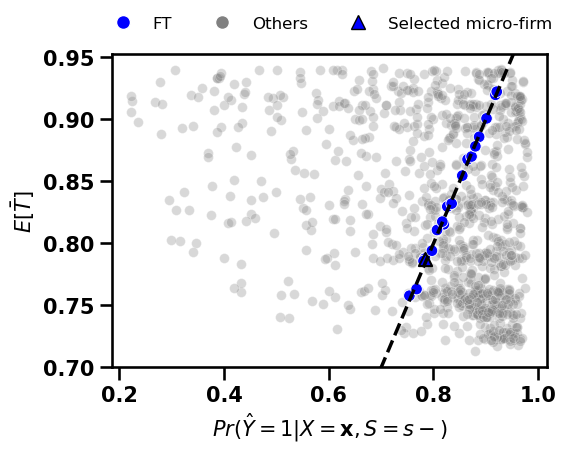

the data ratio is: 0.019860973187686197
blue Protected Pr(Y=1) Mean: 0.8351914040080158, Standard Deviation: 0.050448462302124485
blue Matched Mean Pr(Y=1) Mean: 0.8356905554124469, Standard Deviation: 0.0498731785538363


C:\Users\s2285280\peer-induced-fairness\auditing.py:695: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=False`.
This will become an error in seaborn v0.14.0; please update your code.

  ax = sns.kdeplot(data1, shade=False, color=color, linewidth=7, label='Micro-firms', linestyle='--')
C:\Users\s2285280\peer-induced-fairness\auditing.py:696: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=False`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data2, shade=False, color=density_color, linewidth=7, label='Peers group')


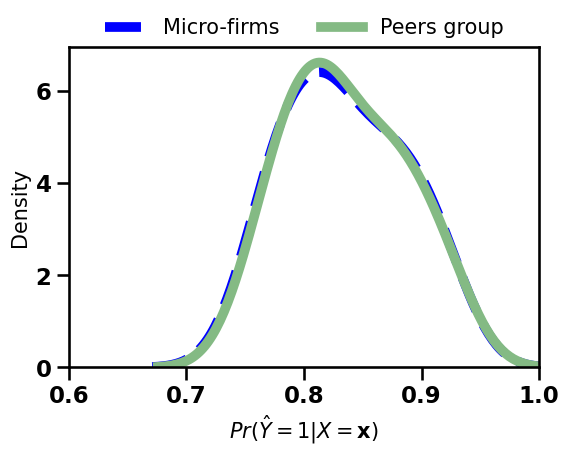

Kurtosis: -0.4350967940080279
Standard Deviation: 0.028403769471892226
Density Mean: 0.7877587908160595
Line Value (A): 0.7835568404151474


C:\Users\s2285280\peer-induced-fairness\auditing.py:1053: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=False`.
This will become an error in seaborn v0.14.0; please update your code.

  ax = sns.kdeplot(data, shade=False, bw_adjust=bw_adjust, color=density_color, linewidth=7, label='Peers')


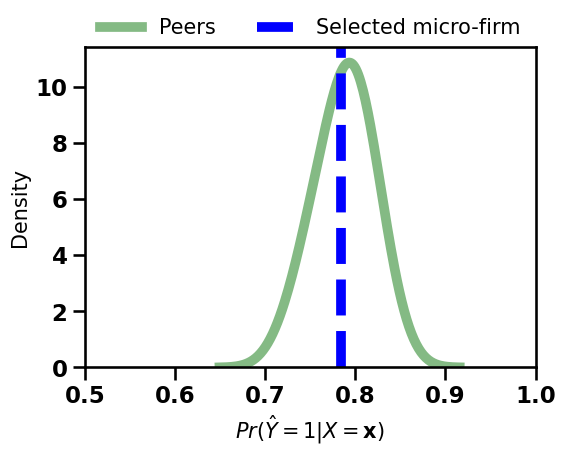

In [25]:
plotter = DensityScatterPlotter(protect_df, nonprotect_df, bootstrapped_samples, result_type='double_sided_results', comparison_type='less than')
double_fair_plot_df, double_fair_gray_df, double_fair_color_df = plotter.plot_scatter(pr_y_means, 604, double_sided_results, threshold_type='floating', floating_ratio=0.1, mean_diff_threshold=treatment_threshold, p_value_threshold=0.05)

plotter.plot_group_density(double_fair_color_df, 'protected Pr(Y=1)', 'matched mean Pr(Y=1)', 'blue', density_color='#84BA84')
plotter.plot_case_density(protect_df,pr_y_means, 604, show_line=True, line_color='blue', density_color='#84BA84')

In [26]:
line_3,b = plotter.try_2(double_fair_color_df,pr_y_means,label='double')

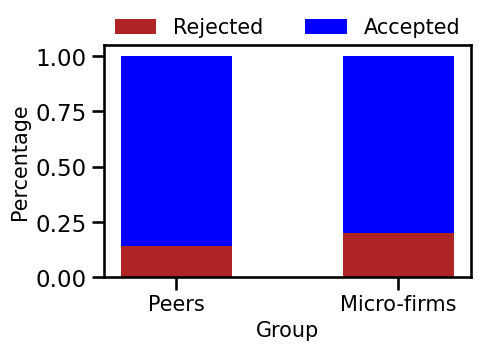

,Type,Binary Y,Count,Proportion
0,Nonprotect,0,8426,0.140433
1,Nonprotect,1,51574,0.859567
2,Protect,0,4,0.200000
3,Protect,1,16,0.800000


In [27]:
double_fair_group_results = plotter.group_ground_truth(double_fair_color_df,label='double')
double_fair_group_results

## 8.4 Slight priviledge

Number of colored points: 242


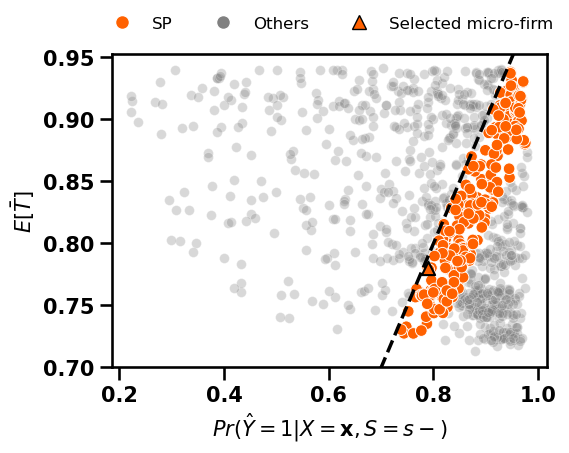

the data ratio is: 0.24031777557100298
#FF6100 Protected Pr(Y=1) Mean: 0.8780865025216077, Standard Deviation: 0.05987391777132078
#FF6100 Matched Mean Pr(Y=1) Mean: 0.8326637877010729, Standard Deviation: 0.058032146693309083


C:\Users\s2285280\peer-induced-fairness\auditing.py:695: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=False`.
This will become an error in seaborn v0.14.0; please update your code.

  ax = sns.kdeplot(data1, shade=False, color=color, linewidth=7, label='Micro-firms', linestyle='--')
C:\Users\s2285280\peer-induced-fairness\auditing.py:696: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=False`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data2, shade=False, color=density_color, linewidth=7, label='Peers group')


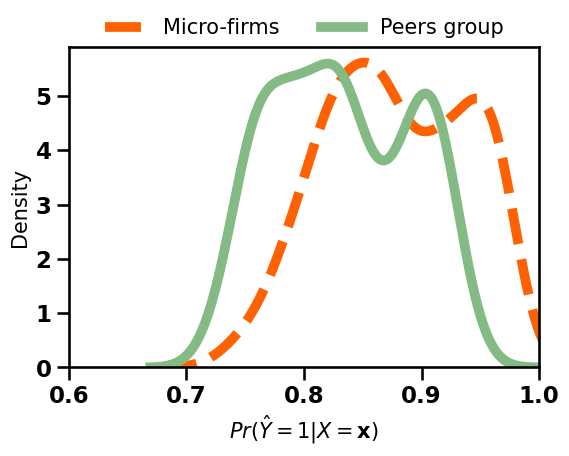

Kurtosis: -0.08634411967793199
Standard Deviation: 0.032224476157173575
Density Mean: 0.7805654603033974
Line Value (A): 0.7888285295466622


C:\Users\s2285280\peer-induced-fairness\auditing.py:1053: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=False`.
This will become an error in seaborn v0.14.0; please update your code.

  ax = sns.kdeplot(data, shade=False, bw_adjust=bw_adjust, color=density_color, linewidth=7, label='Peers')


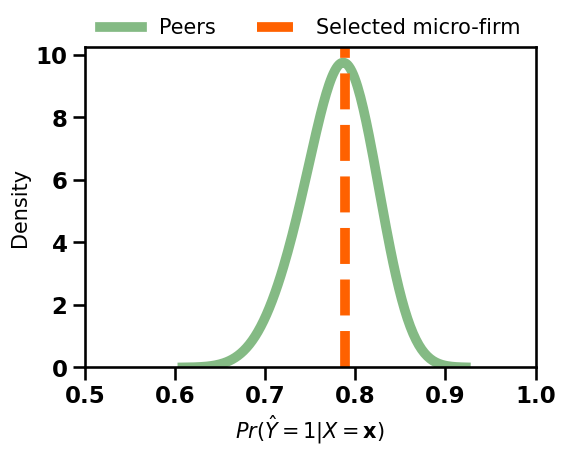

In [28]:
plotter = DensityScatterPlotter(protect_df, nonprotect_df, bootstrapped_samples, result_type='single_less_sided_results', comparison_type='between')
single_less_between_plot_df, single_less_between_gray_df, single_less_between_color_df = plotter.plot_scatter(pr_y_means, 88, single_less_sided_results, threshold_type='floating', floating_ratio=0.1, mean_diff_threshold=treatment_threshold, p_value_threshold=0.05)

plotter.plot_group_density(single_less_between_color_df, 'protected Pr(Y=1)', 'matched mean Pr(Y=1)', '#FF6100', density_color='#84BA84')
plotter.plot_case_density(protect_df,pr_y_means, 88, show_line=True, line_color='#FF6100', density_color='#84BA84')

In [29]:
line_4,b = plotter.try_2(single_less_between_color_df,pr_y_means,label='single_less_between')

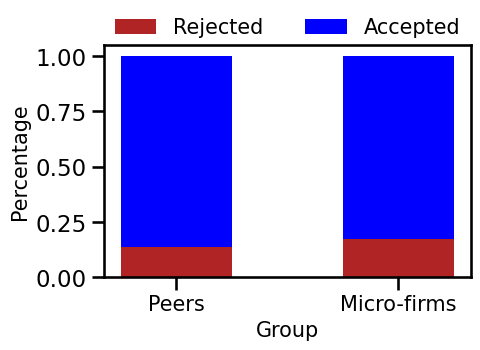

,Type,Binary Y,Count,Proportion
0,Nonprotect,0,100175,0.137982
1,Nonprotect,1,625825,0.862018
2,Protect,0,42,0.173554
3,Protect,1,200,0.826446


In [30]:
single_less_between_group_results = plotter.group_ground_truth(single_less_between_color_df,label='single_less_between')
single_less_between_group_results

## 8.5 Extreme priviledge

Number of colored points: 326


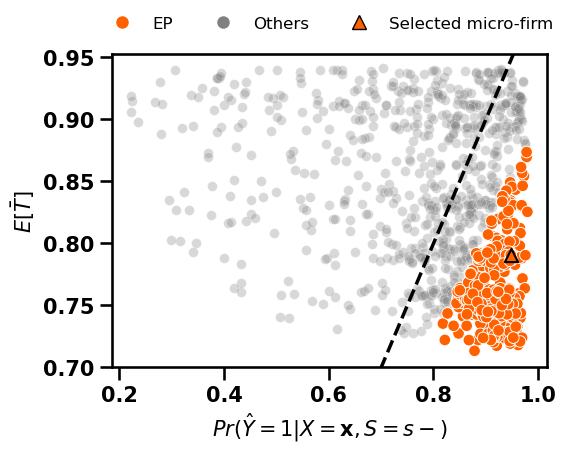

the data ratio is: 0.323733862959285
#FF6100 Protected Pr(Y=1) Mean: 0.9147783354282732, Standard Deviation: 0.03440624610688578
#FF6100 Matched Mean Pr(Y=1) Mean: 0.7640917131171848, Standard Deviation: 0.03259748968026809


C:\Users\s2285280\peer-induced-fairness\auditing.py:695: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=False`.
This will become an error in seaborn v0.14.0; please update your code.

  ax = sns.kdeplot(data1, shade=False, color=color, linewidth=7, label='Micro-firms', linestyle='--')
C:\Users\s2285280\peer-induced-fairness\auditing.py:696: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=False`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data2, shade=False, color=density_color, linewidth=7, label='Peers group')


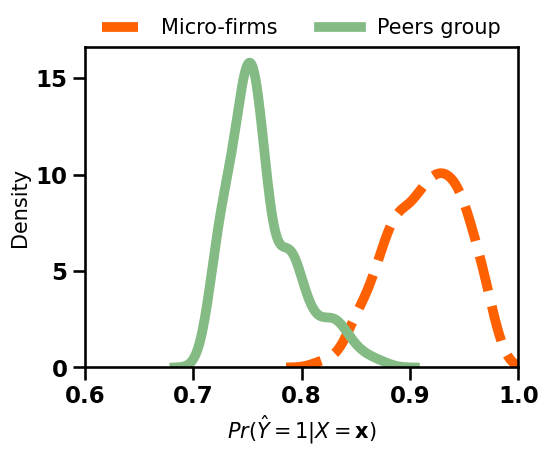

Kurtosis: -0.5320864418073619
Standard Deviation: 0.022261392861685252
Density Mean: 0.7909215434203789
Line Value (A): 0.9476871061703177


C:\Users\s2285280\peer-induced-fairness\auditing.py:1053: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=False`.
This will become an error in seaborn v0.14.0; please update your code.

  ax = sns.kdeplot(data, shade=False, bw_adjust=bw_adjust, color=density_color, linewidth=7, label='Peers')


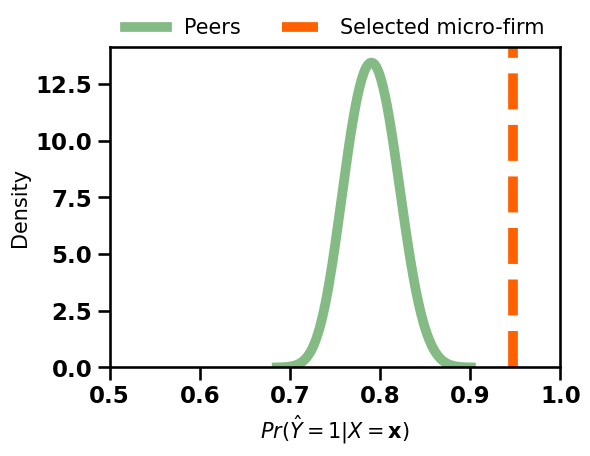

In [31]:
plotter = DensityScatterPlotter(protect_df, nonprotect_df, bootstrapped_samples, result_type='single_less_sided_results', comparison_type='less than')
single_less_less_than_plot_df, single_less_less_than_gray_df, single_less_less_than_color_df = plotter.plot_scatter(pr_y_means, 1718, single_less_sided_results, threshold_type='floating', floating_ratio=0.1, mean_diff_threshold=treatment_threshold, p_value_threshold=0.05)

plotter.plot_group_density(single_less_less_than_color_df, 'protected Pr(Y=1)', 'matched mean Pr(Y=1)', '#FF6100', density_color='#84BA84')
plotter.plot_case_density(protect_df,pr_y_means, 1718, show_line=True, line_color='#FF6100', density_color='#84BA84')

In [32]:
line_5, b = plotter.try_2(single_less_less_than_color_df,pr_y_means,label='single_less_less than')

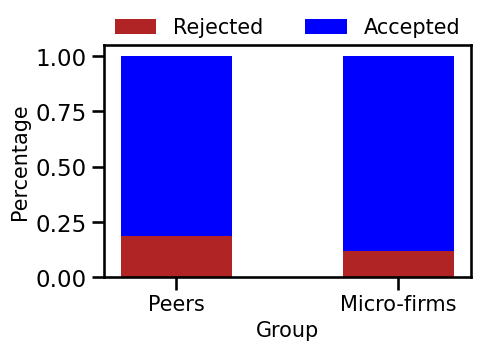

,Type,Binary Y,Count,Proportion
0,Nonprotect,0,180411,0.184469
1,Nonprotect,1,797589,0.815531
2,Protect,0,38,0.116564
3,Protect,1,288,0.883436


In [33]:
single_less_less_than_group_results = plotter.group_ground_truth(single_less_less_than_color_df,label='single_less_less than')
single_less_less_than_group_results

#

# (9) Validation of peer-induced framework 

Difference for ED: 0.42422676579925656
Difference for FT: 0.05956666666666666
Difference for EP: -0.06790490797546014


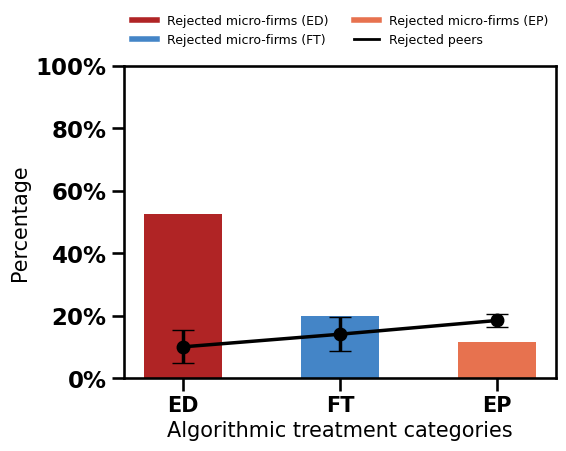

In [34]:
from auditing import DiscriminationBarChart

dfs = [
    single_greater_less_than_group_results,
    double_fair_group_results,
    single_less_less_than_group_results
]


lines=[line_1,line_3,line_5]
plotter = DiscriminationBarChart(dfs, lines, detailed=False)
outcomes_in_discrimination_df = plotter.extract_data()
plotter.plot_stacked_bar_chart()

Difference for ED: 0.42631965174129355
Difference for SD: 0.07242616033755277
Difference for FT: 0.03985185185185183
Difference for SP: 0.03354149659863942
Difference for EP: -0.06655625000000001


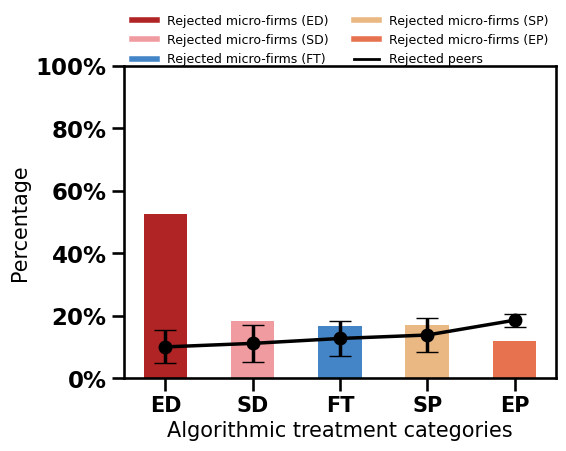

In [87]:
dfs = [
    single_greater_less_than_group_results,
    single_greater_between_group_results,
    double_fair_group_results,
    single_less_between_group_results,
    single_less_less_than_group_results
]


lines=[line_1,line_2,line_3,line_4,line_5]
plotter = DiscriminationBarChart(dfs, lines, detailed=True)
outcomes_in_discrimination_df = plotter.extract_data()
plotter.plot_stacked_bar_chart()

#

# (10) Explanation for fairly treated but rejected individuals

In [35]:
from auditing import BulkCaseAnalysis

double_fairly_treated_df = double_sided_results[double_sided_results['is_significant']=='False']
selected_fairly_protect_df = protect_df.iloc[double_fairly_treated_df['treatment_index'].values]
selected_explanation_rejected_df = selected_fairly_protect_df[selected_fairly_protect_df['Binary Y']==0]
selected_explanation_rejected_df = selected_explanation_rejected_df[~selected_explanation_rejected_df.index.duplicated(keep='first')]
selected_explanation_rejected_df

,risk,principal,legal status,credit purchase,previous turndown,written plan,regular management account,product or service development,business innovation,loss or profit,...,turnover growth rate,Binary Y,new funds injections,new location,new establish time,new size,Pr(S=0),PS Prediction,Pr(Y=1),Binary Prediction
155,4,8,4,1,0,1,0,1,1,2,...,2,0,1,1,1,0,0.220923,1,0.753987,1
325,2,5,1,1,0,0,1,0,0,2,...,2,0,2,0,1,0,0.419330,1,0.819800,1
609,4,9,4,0,0,1,1,1,1,1,...,3,0,2,0,1,0,0.380624,1,0.797034,1
1211,3,9,4,0,0,1,1,0,1,1,...,2,0,2,0,1,0,0.480447,1,0.834718,1


In [36]:
greater_features = ['regular management account', 'credit purchase', 'new location',
            'finance qualification for manager', 'loss or profit', 'new funds injections',
            'legal status', 'principal', 'written plan']
less_features = ['new establish time', 'turnover growth rate', 'risk', 'previous turndown',
            'business innovation', 'product or service development']
        
        
bulk_analysis = BulkCaseAnalysis(protect_df, nonprotect_df, matched_df, selected_explanation_rejected_df)
significant_proportions = bulk_analysis.perform_bulk_analysis(less_features, greater_features, 'one_2_accepted_group',side='less')
significant_proportions

C:\Users\s2285280\AppData\Local\anaconda3\lib\site-packages\scipy\stats\_axis_nan_policy.py:502: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)
C:\Users\s2285280\AppData\Local\anaconda3\lib\site-packages\scipy\stats\_axis_nan_policy.py:502: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)
C:\Users\s2285280\AppData\Local\anaconda3\lib\site-packages\scipy\stats\_axis_nan_policy.py:502: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)
C:\Users\s2285280\AppData\Local\anaconda3\lib\site-packages\scipy\s

,significant_proportion
feature,
principal,0.0%
previous turndown,0.0%
Binary Prediction,100.0%
new size,100.0%
new establish time,100.0%
Pr(S=0),100.0%
Binary Y,100.0%
Pr(Y=1),100.0%
finance qualification for manager,25.0%


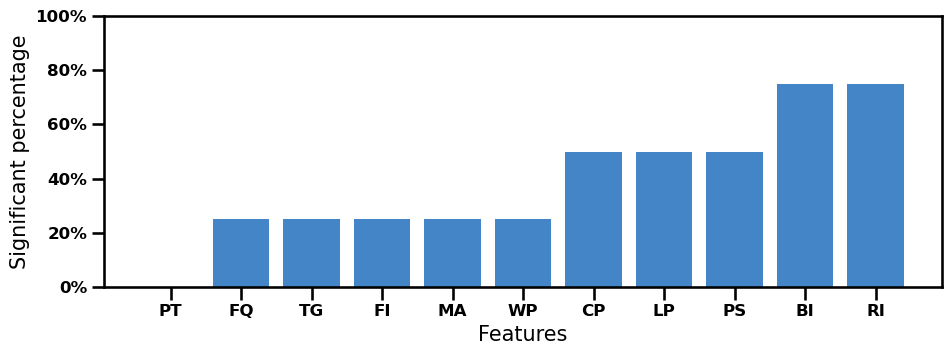

In [37]:
import pandas as pd
import matplotlib.pyplot as plt

# Copy and convert the significant_proportion column to numeric and scale it
df = significant_proportions.copy()
df = df.reset_index()
df['significant_proportion'] = df['significant_proportion'].str.replace('%', '').astype(float) / 100.0

# Define the selected features
selected_features = ['risk', 'turnover growth rate', 'loss or profit', 'written plan',
                     'regular management account', 'business innovation', 'credit purchase', 
                     'product or service development', 'finance qualification for manager', 
                     'new funds injections', 'previous turndown']

# Filter and sort the DataFrame
selected_df = df[df['feature'].isin(selected_features)]
selected_df = selected_df.sort_values(by='significant_proportion').reset_index(drop=True)

# Map short feature names
short_features = {
    'risk': 'RI', 
    'turnover growth rate': 'TG', 
    'loss or profit': 'LP', 
    'written plan': 'WP', 
    'regular management account': 'MA', 
    'business innovation': 'BI',  
    'credit purchase': 'CP', 
    'product or service development': 'PS', 
    'finance qualification for manager': 'FQ', 
    'new funds injections': 'FI',
    'previous turndown': 'PT'
}
selected_df['short_feature'] = selected_df['feature'].map(short_features)

# Plotting the bar chart
plt.figure(figsize=(10, 4))
plt.bar(selected_df['short_feature'], selected_df['significant_proportion'], color='#4485C7', width=0.8)
plt.xlabel('Features', fontsize=15)
plt.ylabel('Significant percentage', fontsize=15)
plt.ylim(0, 1)  # y-axis from 0 to 1 (100%)
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: '{:.0%}'.format(x)))  # y-axis as percentage
plt.tight_layout()

# Set font size for tick labels
plt.xticks(fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')

# Save the chart as a PDF
plt.savefig('nonintrinsic_detailed_significant_percentage.pdf', format='pdf', dpi=300)

# Display the chart
plt.show()